# Epicurious Data Analysis

**Autor:** Raphael Brito Alencar

**Linguagem:** Python 

**Descrição:** Análise dos dados coletados do site https://www.epicurious.com/

**Data:** 12/01/2020

In [1]:
# carregando libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr, norm, probplot

from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag, word_tokenize
import re

import json
import gc

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rochelle0liveira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rochelle0liveira/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Utils
# percentual de preenchimento de cada feature
def show_filling_factor(data):
    missing_df = data.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['variable', 'missing values']
    missing_df['filling factor (%)'] = ((data.shape[0] - missing_df['missing values']) / data.shape[0]) * 100
    return missing_df.sort_values('filling factor (%)').reset_index(drop = True)

# histograma e normal probability plot
def create_hist_prob_plot(ser):
    sns.distplot(ser, fit=norm);
    fig = plt.figure()
    res = probplot(ser, plot=plt)
    
# transformar para log
def log_transform(ser):
    return ser.map(lambda i: np.log(i) if i > 0 else 0)

def fillna_outlier_median(col):
    # substituindo valores de outliers e valores faltantes pela mediana 
    IQR = iqr(data[col], nan_policy='omit')
    upper_bound = data[col].quantile(0.75) + 1.5 * IQR
    lower_bound = data[col].quantile(0.25) - 1.5 * IQR
    
    outliers = data[(data[col] > upper_bound) | (data[col] < lower_bound)]
    outliers_idx = outliers.index
    
    median = data[~data.isin(outliers)][col].median()
    
    data.loc[outliers_idx, col] = median
    data[col].fillna(median, inplace=True)
    
    return data[col].describe().round(decimals=2).drop('count')

def skew_kurt(col):
    # skewness e kurtosis
    print("Skewness: %f" % data[col].skew())
    print("Kurtosis: %f" % data[col].kurt())

def count_sublist_values(data,sublist):
    series = list()
    for i in data.index:
        try:
            t = data.loc[i, sublist]
            for j in t:
                series.append(j)
        except:
            pass
    return pd.Series(series)

def sublist_uniques(data,sublist):
    categories = set()
    for i in data.index:
        try:
            t = data.loc[i, sublist]
            for j in t:
                categories.add(j)
        except:
            pass
    return list(categories)

In [3]:
# carregando dados de receitas.json
# verificando os primeiros registros
data = pd.read_json('receitas.json')
data.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


In [4]:
data.shape

(20130, 11)

In [5]:
# informações sobre as colunas do dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20130 entries, 0 to 20129
Data columns (total 11 columns):
directions     20111 non-null object
fat            15908 non-null float64
date           20111 non-null datetime64[ns, UTC]
categories     20111 non-null object
calories       15976 non-null float64
desc           13495 non-null object
protein        15929 non-null float64
rating         20100 non-null float64
title          20111 non-null object
ingredients    20111 non-null object
sodium         15974 non-null float64
dtypes: datetime64[ns, UTC](1), float64(5), object(5)
memory usage: 1.7+ MB


In [6]:
# descrevendo estatísticas dos valores numéricos
# resultado sem dados tratados
data.describe().round(decimals=2)

,fat,calories,protein,rating,sodium
count,15908.00,15976.00,15929.00,20100.00,15974.00
mean,346.10,6307.86,99.95,3.71,6211.47
std,20431.02,358585.12,3835.62,1.34,332890.25
min,0.00,0.00,0.00,0.00,0.00
25%,7.00,198.00,3.00,3.75,80.00
50%,17.00,331.00,8.00,4.38,294.00
75%,33.00,586.00,27.00,4.38,711.00
max,1722763.00,30111218.00,236489.00,5.00,27675110.00


Alguns fatos observados na descrição estatística das features:
* Temos valores extremos para fat, calories, protein e sodium
* Um alto numero de ratings 4.38, o que parece um erro

Removendo registros duplicados, ou seja, receitas com o mesmo título:

In [7]:
# verificando registros duplicados
print('Número de receitas duplicadas: {}'.format(data.duplicated('title').sum()))

Número de receitas duplicadas: 2354


In [8]:
# removendo registros duplicados
data.drop_duplicates('title', keep='first', inplace=True)
data.shape

(17776, 11)

Verificando registros nulos:

In [10]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5859,67.039829
1,fat,3732,79.005401
2,protein,3713,79.112286
3,sodium,3689,79.247300
4,calories,3688,79.252925
5,rating,10,99.943744
6,directions,1,99.994374
7,date,1,99.994374
8,categories,1,99.994374
9,title,1,99.994374


Olhando a tabela acima, parece que os registros nulos são os mesmos para categories, date, directions, ingredients e title. No caso, 1 registro. Verificando:

In [11]:
# tratando valores nulos
data[data['categories'].isna()]

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
1076,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# excluindo registros totalmente nulos
data.drop(data[data['categories'].isna()].index, inplace=True)

show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.043601
1,fat,3731,79.009845
2,protein,3712,79.116737
3,sodium,3688,79.251758
4,calories,3687,79.257384
5,rating,9,99.949367
6,directions,0,100.000000
7,date,0,100.000000
8,categories,0,100.000000
9,title,0,100.000000


Visualizando a matriz de correlação entre as variáveis nutricionais de cada receita:

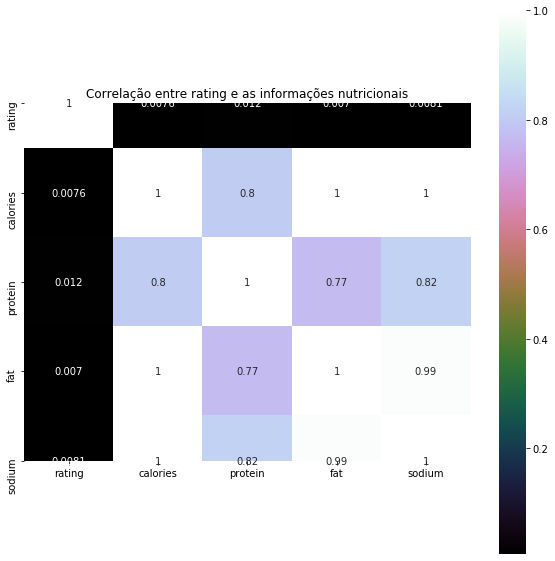

In [13]:
# verificando correlação entre variaveis numericas
cols = ['rating', 'calories', 'protein', 'fat', 'sodium']

plt.figure(figsize=(10,10))
sns.heatmap(data[cols].corr(), vmax=1, square=True,annot=True,cmap='cubehelix')
plt.title('Correlação entre rating e as informações nutricionais')
plt.show()

As variáveis nutricionais se correlacionam de forma positiva de acordo com o coeficiente de Pearson mostrado no heatmap acima. Fica claro, também, que ás variáveis **sodium** e **calories** são as que se correlacionam melhor com a variável **rating**.

Vamos analisar cada variável separadamente para tirarmos algumas conclusões:

### rating

In [14]:
data['rating'].describe().round(decimals=2).drop('count')

mean    3.72
std     1.32
min     0.00
25%     3.75
50%     4.38
75%     4.38
max     5.00
Name: rating, dtype: float64

In [15]:
data[data['rating'].isna()]

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
560,"[Whisk chile, oil, lime juice, soy sauce, brow...",39.0,2013-04-05 04:00:00+00:00,[],508.0,Although it's reason alone to keep a rotisseri...,25.0,NaN,Asian Chicken and Cabbage Salad,[1 red jalapeño or Fresno chile with some seed...,538.0
1749,[Whisk together sauce ingredients in a bowl un...,22.0,2012-11-27 04:00:00+00:00,[],579.0,We like to think of the summer roll as an eleg...,20.0,NaN,Spicy Summer Rolls with Peanut Dipping Sauce,"[2/3 cup hoisin sauce (see Cooks' notes:), 1/3...",1160.0
3931,[Beat 1/2 cup cream in a medium bowl until sti...,17.0,2013-01-07 04:00:00+00:00,[],255.0,Dark chocolate and espresso add the slightly b...,5.0,NaN,Classic Chocolate Mousse,"[3/4 cup chilled heavy cream, divided, 4 large...",74.0
4036,"[Preheat oven to 450°F. Cut top 1/2"" off head ...",NaN,2011-08-10 04:00:00+00:00,[],NaN,"At Philadelphia's Bindi, legumes and rice are ...",NaN,NaN,South Indian Lentil Cakes with Raita,"[1 head of garlic, 1 tablespoon extra-virgin o...",NaN
8262,"[Preheat oven to 400°. Wash beets, leaving som...",0.0,2011-12-09 04:00:00+00:00,[],117.0,Our fresh take on the classic Moroccan salad p...,3.0,NaN,"Blood Orange, Beet, and Fennel Salad","[2 medium red beets, tops trimmed, 2 medium go...",51.0
11763,"[Grill bread slices., Halve, pit, and thinly s...",NaN,2011-05-17 04:00:00+00:00,[],NaN,This is inspired by the Italian combination of...,NaN,NaN,"Peach, Prosciutto & Ricotta Crostini","[12 slices ciabatta bread, 1 ripe peach, 1 tab...",NaN
12077,[Place pears and granulated sugar in a medium ...,18.0,2013-09-18 04:00:00+00:00,[],355.0,"When we were first dating, we would stay up in...",4.0,NaN,Tarte Bourdaloue,"[2 Bosc or Anjou pears, peeled, cored and quar...",269.0
13781,"[In a large bowl, whisk together tamari, 1 tab...",NaN,2014-05-09 04:00:00+00:00,[],NaN,Crisp julienned vegetables add crunchy texture...,NaN,NaN,Sesame Rice Noodles with Shrimp,"[1/4 cup gluten-free tamari or soy sauce, 1/4 ...",NaN
16839,"[Mix almonds, chives, parsley, and 1 tablespoo...",NaN,2014-03-26 04:00:00+00:00,[],NaN,Almonds are the new breadcrumbs. Their toasty ...,NaN,NaN,Linguine and Clams with Almonds and Herbs,"[1/2 cup unsalted, roasted almonds, coarsely c...",NaN


Analisando os 9 registros com valores faltantes de **rating** percebe-se que a maior parte das features para esses registros são nulas. Excluí-los não deve afetar nossa análise.

In [16]:
data.drop(data[data['rating'].isna()].index, inplace=True)

In [17]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.026905
1,fat,3727,79.021727
2,protein,3708,79.128673
3,sodium,3684,79.263762
4,calories,3683,79.269391
5,directions,0,100.000000
6,date,0,100.000000
7,categories,0,100.000000
8,rating,0,100.000000
9,title,0,100.000000


Verificando a distribuição de **rating**:

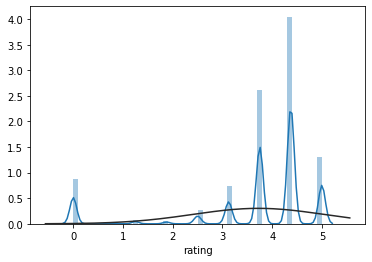

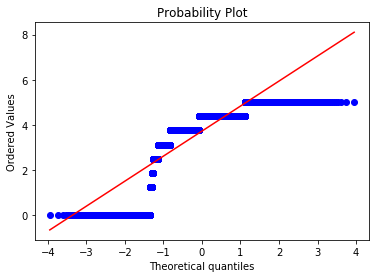

In [18]:
create_hist_prob_plot(data['rating'])

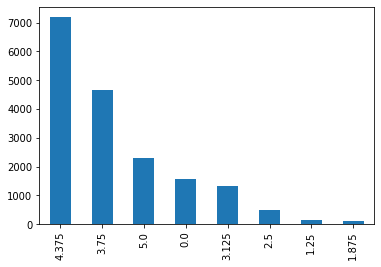

In [19]:
data['rating'].value_counts().plot.bar()
plt.show()

Um grande número de avaliações 4.375. Aparentemente algum erro!

### fat

In [20]:
data['fat'].describe().round(decimals=2).drop('count')

mean        373.50
std       21668.02
min           0.00
25%           9.00
50%          18.00
75%          35.00
max     1722763.00
Name: fat, dtype: float64

In [21]:
skew_kurt('fat')

Skewness: 74.252119
Kurtosis: 5747.229472


**Skewness** é o grau de distorção da curva simétrica ou da distribuição normal. Mede a falta de simetria na distribuição dos dados, diferenciando valores extremos. Uma distribuição simétrica terá skewness 0.

**Kurtosis** mostra tudo sobre a calda da distribuição. É usado para descrever os valores extremos, sendo na verdade a medida de outliers existentes na distribuição.

Percebemos um valor para o Kurtosis muito alto (High Kurtosis), indicando que temos muitos outliers. Vamos ajustá-los e também preencher os valores faltantes com a média, utilizando a técnica de **IQR Score**: 

* Essa técnica será aplicada as próximas features quando necessário

In [22]:
# preenchendo valores faltantes e outliers com mediana
fillna_outlier_median('fat')

mean    19.82
std     14.87
min      0.00
25%     11.00
50%     17.00
75%     24.00
max     74.00
Name: fat, dtype: float64

In [23]:
skew_kurt('fat')

Skewness: 1.333320
Kurtosis: 1.859364


In [24]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.026905
1,protein,3708,79.128673
2,sodium,3684,79.263762
3,calories,3683,79.269391
4,directions,0,100.000000
5,fat,0,100.000000
6,date,0,100.000000
7,categories,0,100.000000
8,rating,0,100.000000
9,title,0,100.000000


Apresentando a distribuição da variável **fat** e gerando um gráfico de probabilidade dos dados em relação aos quantis de uma distribuição normal:

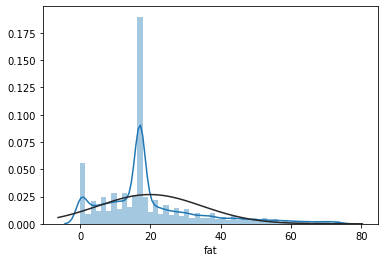

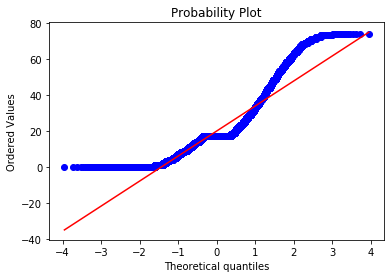

In [25]:
create_hist_prob_plot(data['fat'])

Plotando um boxplot para visualizar a posição, simetria, dispersão e valores discrepantes dos dados da feature **fat**:

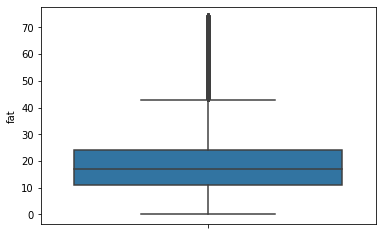

In [26]:
sns.boxplot(y=data['fat'])
plt.show()

### protein

In [27]:
data['protein'].describe().round(decimals=2).drop('count')

mean        94.60
std       3562.82
min          0.00
25%          3.00
50%          9.00
75%         29.00
max     236489.00
Name: protein, dtype: float64

In [28]:
skew_kurt('protein')

Skewness: 55.047617
Kurtosis: 3177.812071


A feature **protein** também possui muitos valores extremos. Vamos tratá-los junto com os valores faltantes assim como foi feito com fat.

In [29]:
# preenchendo valores faltantes e outliers com mediana
fillna_outlier_median('protein')

mean    13.30
std     14.34
min      0.00
25%      5.00
50%      8.00
75%     16.00
max     68.00
Name: protein, dtype: float64

In [30]:
skew_kurt('protein')

Skewness: 1.777203
Kurtosis: 2.487228


In [31]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.026905
1,sodium,3684,79.263762
2,calories,3683,79.269391
3,directions,0,100.000000
4,fat,0,100.000000
5,date,0,100.000000
6,categories,0,100.000000
7,protein,0,100.000000
8,rating,0,100.000000
9,title,0,100.000000


Visualizando a distribuição de **protein**

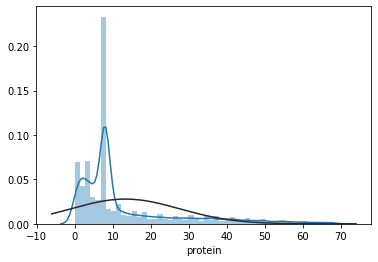

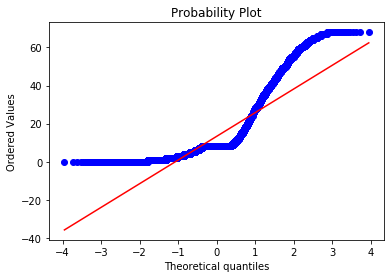

In [32]:
create_hist_prob_plot(data['protein'])

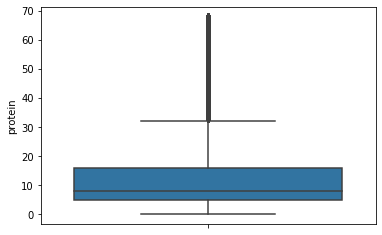

In [33]:
sns.boxplot(y=data['protein'])
plt.show()

### calories

In [34]:
data['calories'].describe().round(decimals=2).drop('count')

mean        6808.42
std       380315.15
min            0.00
25%          208.00
50%          351.00
75%          605.00
max     30111218.00
Name: calories, dtype: float64

In [35]:
skew_kurt('calories')

Skewness: 73.236272
Kurtosis: 5635.426321


Vamos resolver os valores faltantes e outliers de **calories** da mesma forma que os anteriores.

In [36]:
# preenchendo valores faltantes e outliers com mediana
fillna_outlier_median('calories')

mean     377.61
std      225.54
min        0.00
25%      242.00
50%      327.00
75%      460.00
max     1200.00
Name: calories, dtype: float64

In [37]:
skew_kurt('calories')

Skewness: 1.246337
Kurtosis: 1.556509


In [38]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.026905
1,sodium,3684,79.263762
2,directions,0,100.000000
3,fat,0,100.000000
4,date,0,100.000000
5,categories,0,100.000000
6,calories,0,100.000000
7,protein,0,100.000000
8,rating,0,100.000000
9,title,0,100.000000


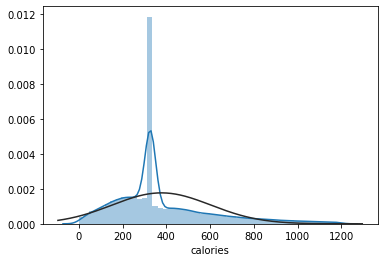

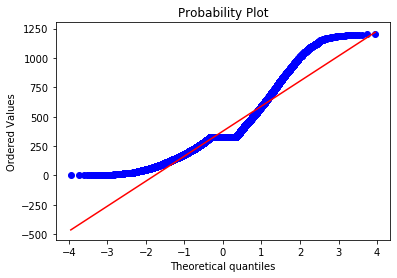

In [39]:
create_hist_prob_plot(data['calories'])

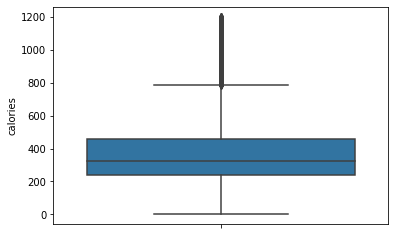

In [40]:
sns.boxplot(y=data['calories'])
plt.show()

### sodium

In [41]:
data['sodium'].describe().round(decimals=2).drop('count')

mean        6758.43
std       353561.36
min            0.00
25%           92.00
50%          310.00
75%          740.00
max     27675110.00
Name: sodium, dtype: float64

In [42]:
skew_kurt('sodium')

Skewness: 71.340269
Kurtosis: 5396.853017


In [43]:
# preenchendo valores faltantes e outliers com mediana
fillna_outlier_median('sodium')

mean     368.81
std      352.50
min        0.00
25%      137.00
50%      268.00
75%      462.00
max     1712.00
Name: sodium, dtype: float64

In [44]:
skew_kurt('sodium')

Skewness: 1.609521
Kurtosis: 2.240760


In [45]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.026905
1,directions,0,100.000000
2,fat,0,100.000000
3,date,0,100.000000
4,categories,0,100.000000
5,calories,0,100.000000
6,protein,0,100.000000
7,rating,0,100.000000
8,title,0,100.000000
9,ingredients,0,100.000000


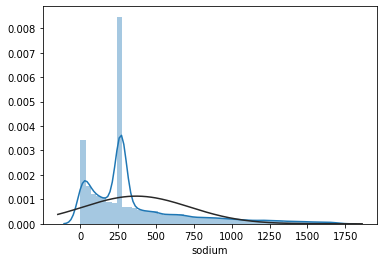

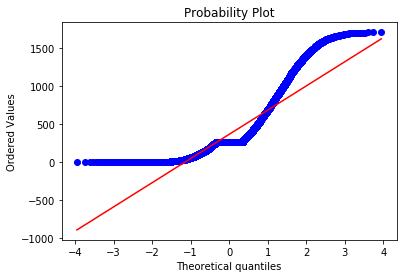

In [46]:
create_hist_prob_plot(data['sodium'])

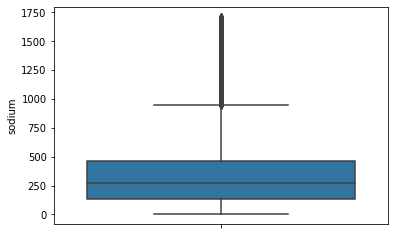

In [47]:
sns.boxplot(y=data['sodium'])
plt.show()

### categories

Verificando as 10 categorias mais utilizadas:

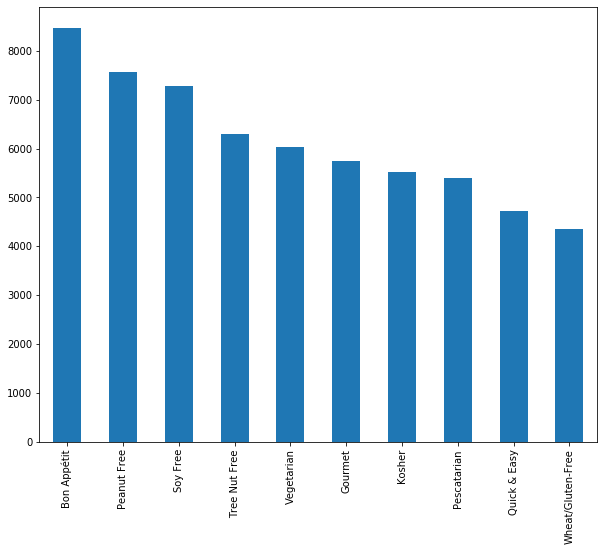

Em um total de  673 categorias


In [48]:
# Quantas vezes cada categoria aparece
cat = count_sublist_values(data, 'categories')

# plot top 10 categorias usadas
plt.figure(figsize=(10,8))
cat.value_counts().nlargest(10).plot.bar()
plt.show()

unique_cat = sublist_uniques(data, 'categories')
print('Em um total de  \u001b[1m{} categorias'.format(len(unique_cat)))

#### 1) A que categorias pertencem as comidas mais calóricas?
* Foram selecionadas as 5 receitas mais caloricas para a análise

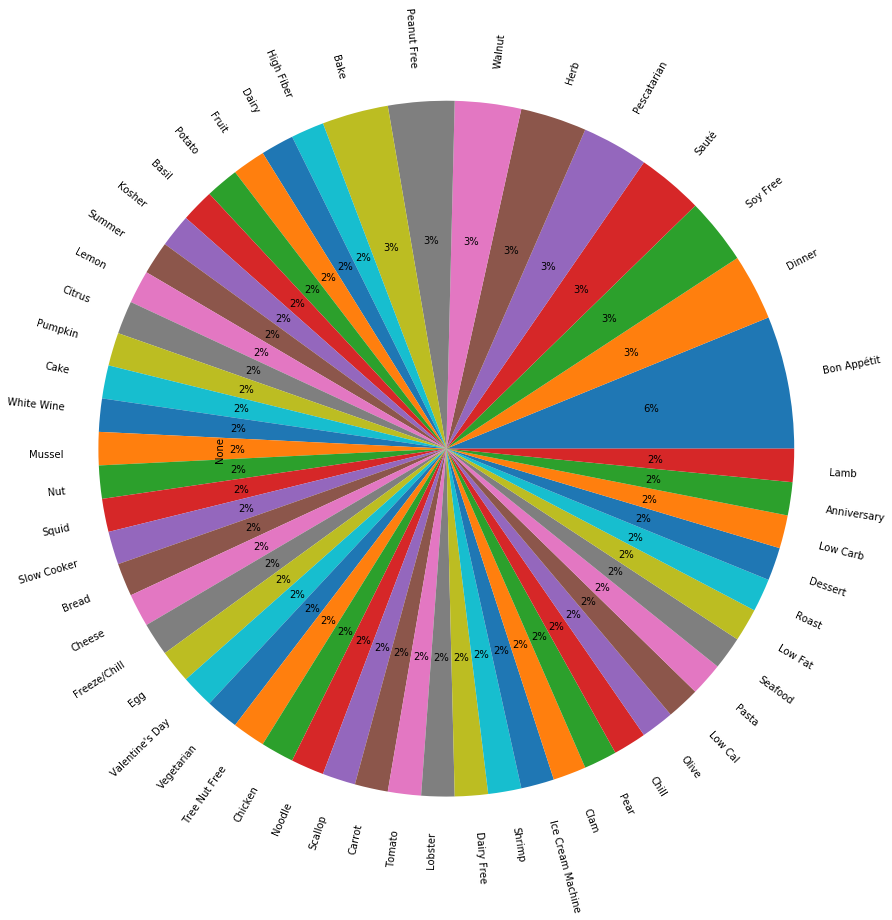

In [49]:
# 5 receitas mais caloricas e suas categorias
cal_receipts = data.nlargest(5, columns='calories')
cal_receipts_unique_cat = count_sublist_values(cal_receipts, 'categories')

plt.figure(figsize=(8, 8))
cal_receipts_unique_cat.value_counts().plot.pie(rotatelabels=True, autopct='%1.0f%%', radius=2.0)
plt.show()

**6%** das **receitas mais calóricas** são categorizadas com **Bon Appétit**, sendo essa a categoria mais comum num total de **54** usadas nas receitas mais caóricas.

Criando uma nuvem de palavras para melhorar a visualização das categorias mais usadas:

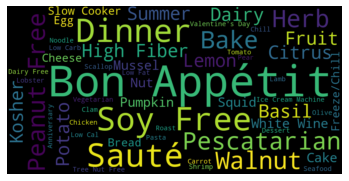

In [50]:
wordCloud = WordCloud(width=1000, height=500).generate_from_frequencies(cal_receipts_unique_cat.value_counts())
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### ingredients

A coluna **ingredients** possui uma lista de ingredientes, com suas quantidades entre outras informações, para cada registro. A abordagem utilizada para identificar os ingredientes e criar uma lista mais limpa, foi utilizada a lib **nltk** para extrair apenas substantivos.

In [51]:
data.reset_index(drop=True, inplace=True)

# extraindo ingredientes de cada registro
recipe_ingredients = [] # armazena os ingredientes de cada receita
ingredients_list = [] # lista com todos ingredientes presentes nos dados

for i in range(len(data['ingredients'])):
    recipe_ingredients.append([])
    
    for j in range(len(data['ingredients'][i])):
        tokenized_ingredients = nltk.word_tokenize(data['ingredients'][i][j])
        
        # lista de tags https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html    
        tagged_ingredients = nltk.pos_tag(tokenized_ingredients)         
        tagged_ingredients = [k for k in tagged_ingredients if (k[1] == 'NN' or k[1] == 'NNS') and (re.match('[^0-9]', k[0]))]
        tagged_ingredients = tagged_ingredients[-1:]
        
        if len(tagged_ingredients) != 0:
            recipe_ingredients[i].append(tagged_ingredients[0][0]) # adicionando apenas o token
            ingredients_list.append(tagged_ingredients[0][0])

#### 2) Quais os top 10 ingredientes contidos nas receitas mais calóricas?

In [52]:
# transformando a coluna ingredients
ingredients = pd.Series(recipe_ingredients, name='ingredients')
data['ingredients'] = ingredients
data.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[stock, lentils, lentils, celery, carrot, thym...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[cream, onions, salt, leaves, cloves, clove, p...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[garnish, onion, butter, potatoes, broth, milk]",165.0
3,[Heat oil in heavy large skillet over medium-h...,17.0,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",327.0,The Sicilian-style tomato sauce has tons of Me...,8.0,5.000,Mahi-Mahi in Tomato Olive Sauce,"[oil, onion, wine, paste, juice, fillets, oliv...",268.0
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[soufflé, noodles, cream, sauce, nutmeg, cheese]",452.0


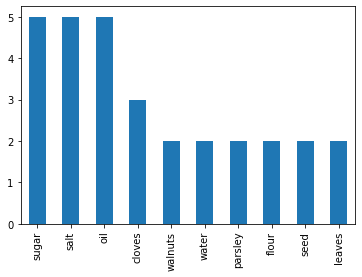

In [53]:
# retornando as receitas mais caloricas
cal_receipts = data.nlargest(5, columns='calories')
cal_receipts_unique_ing = count_sublist_values(cal_receipts, 'ingredients')
cal_receipts_unique_ing.value_counts().nlargest(10, keep='first').plot.bar() 
plt.show()

Era de se esperar que sal, açucar e oleo fossem os ingredientes mais utilizados. Estes são ingredientes quase que indispensáveis em receitas mais caloricas.

Saindo agora do escopo de ingredientes e respondendo a mais algumas questões:

#### 3) Se você tivesse que recomendar 3 receitas baseando-se nos dados, quais seriam?

Uma boa receita é aquela que tem valores nutricionais balanceados. Para o caso, uma receita com baixa caloria e alta proteína deve ser uma boa escolha.

In [54]:
# selecionando as receitas com avaliação 5.0
five_aval_recipe = data[data['rating'] == 5.0]
print('A base de dados é composta por {} receitas com avaliação 5.0'.format(five_aval_recipe.shape[0]))

A base de dados é composta por 2311 receitas com avaliação 5.0


Dividindo os dados em intervalos de tamanho igual de acordo com os quantis da amostra de dados e armazenando em uma coluna calories_bin:


In [55]:
a = pd.qcut(five_aval_recipe['calories'], [0, .33, .66, 1], labels=['low', 'med', 'high']).rename('calories_bin')

five_aval_recipe = five_aval_recipe.join(a)

Para selecionar as melhores receitas, o retangulo desenhado em vermelho irá enquadrá-las.

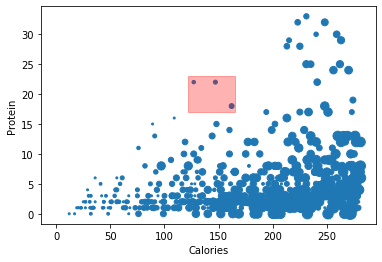

In [56]:
# selecionando receitas com avaliação 5.0 e baixa caloria
low = five_aval_recipe.loc[five_aval_recipe['calories_bin'] == 'low']

# plotando calories x protein com os tamanhos das marcas baseado na variavel fat
plt.scatter(x='calories', y='protein', s=low['fat'] * 4, data=low)

plt.xlabel('Calories')
plt.ylabel('Protein')

# marcando as 3 receitas a serem recomendadas
plt.axhspan(ymin=17, ymax=23, xmin=.44, xmax=.58, alpha=.3, color='r')
plt.show()

In [57]:
# selecionando as 3 receitas demarcadas no retangulo vermelho
low.loc[(low['protein'] > 17) & (low['calories'] < 170)]

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium,calories_bin
5117,"[In large saucepan, combine low-salt chicken b...",6.0,2007-10-01 21:17:01+00:00,"[Soup/Stew, turkey, Thanksgiving, Low Fat, Low...",162.0,All of the gravy recipes here call for this en...,18.0,5.0,Shortcut Turkey Stock,"[broth, chunks, chunks, onion, parsley, gizzard]",278.0,low
5793,[Cut neck crosswise into 1 1/2-inch pieces. Me...,3.0,2004-08-20 04:00:00+00:00,"[Sauce, Soup/Stew, Onion, turkey, Thanksgiving...",127.0,None,22.0,5.0,Giblet Stock,"[turkey, butter, onions, carrots, leaves, brot...",95.0,low
13243,[Coarsely grind first 5 ingredients in spice m...,4.0,2008-09-30 04:00:00+00:00,"[turkey, Marinate, Roast, Thanksgiving, Dinner...",147.0,This recipe has subtle Asian flavors that deli...,22.0,5.0,"Salted Roast Turkey with Orange, Fall Spices, ...","[anise*, peppercorns**, cloves, seeds, seeds, ...",763.0,low


In [58]:
suggested_recipe = low.loc[(low['protein'] > 17) & (low['calories'] < 170), 'title']
print('Sendo assim, as 3 receitas sugeridas são:\n ')

for rec in suggested_recipe.values:
    print('\033[1m' + rec + '\033[0m')

Sendo assim, as 3 receitas sugeridas são:
 
Shortcut Turkey Stock 
Giblet Stock 
Salted Roast Turkey with Orange, Fall Spices, and Sherry Gravy 


#### 4) Alguma característica presente nos dados determina a alta nota de uma receita?

Plotando gráfico das informações nutricionais em relação a variável **rating**. Esse gráfico mostrará quais dessas informações determinam melhores avaliações.

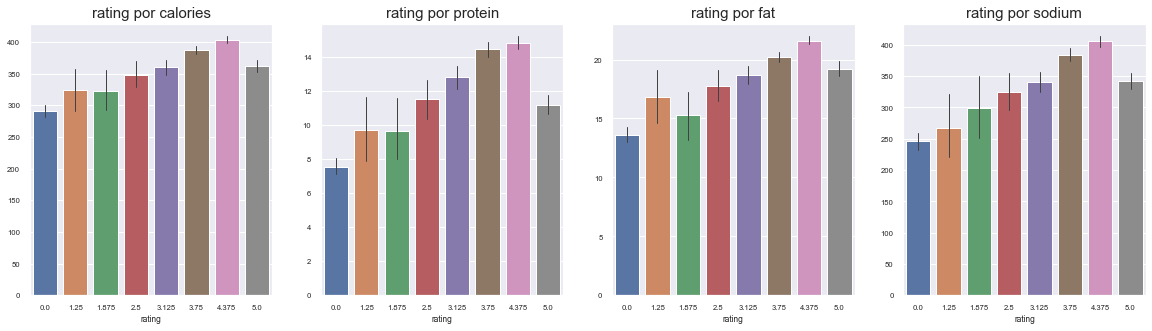

In [59]:
dict_plt = {0:'calories',1:'protein',2:'fat',3:'sodium'}

sns.set(font_scale=.7)

fig, ax = plt.subplots(1, 4, figsize=(20,5))

for i in range(4):
    sns.barplot(x='rating',y=dict_plt[i], data=data, ax=ax[i], errwidth=1)
    ax[i].set_title('rating por {}'.format(dict_plt[i]), size=15)
    ax[i].set_ylabel('')

De acordo com os gráficos de barras acima, identifica-se que as receitas com melhor avaliação são aquelas **mais calóricas** e com **muito sódio**. 

#### 5) Considerando-se as categorias das top 100 receitas em avaliação, quantas receitas há atualmente no site https://www.epicurious.com para cada categoria

Verificando as 100 receitas mais recentes e com melhores avaliações:

In [60]:
# usando as ultimas de acordo com a data
top_100_rating_recipe = data.sort_values('date', ascending=False).nlargest(100, columns='rating')
top_100_rating_recipe

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
4660,[Arrange a rack in center of oven; preheat to ...,65.0,2016-11-27 18:46:20.583000+00:00,"[Vegetarian, Rice, Dinner, Orange, Parsnip, Ri...",935.0,This simple rice salad combines hearty parsnip...,18.0,5.0,Vegetarian Brown Rice Salad With Parsnips and ...,"[rice, oil, salt, oranges, coins, clove, sprig...",1061.0
15610,"[Working one at a time, place turkey breast, s...",36.0,2016-11-24 02:46:00+00:00,"[Friendsgiving, Thanksgiving, Dinner, Butternu...",631.0,"For maximum juiciness and flavor, pound and se...",59.0,5.0,"Stuffed Turkey Breast With Butternut Squash, K...","[breasts, salt, pepper, fennel, oil, casings, ...",1335.0
8481,[Heat milk in a small saucepan over low until ...,5.0,2016-11-23 20:30:00+00:00,"[Bread, Dinner, Christmas, Thanksgiving, Bake,...",122.0,"One simple master recipe, based on a classic F...",2.0,5.0,Dinner Rolls Six Ways,"[milk, teaspoons, salt, flour, honey, tablespo...",243.0
6319,[Heat butter and brown sugar in a small saucep...,26.0,2016-11-22 17:36:17.100000+00:00,"[Bon Appétit, Thanksgiving, Pie, Sweet Potato/...",409.0,We tested this pie recipe with canned sweet po...,6.0,5.0,Sweet Potato–Miso Pie With Chocolate-Sesame Cr...,"[butter, sugar, seeds, pieces, salt, pound, su...",334.0
17256,"[Preheat oven to 300°F. Butter a shallow 13x9""...",36.0,2016-11-21 23:33:04.148000+00:00,"[Bon Appétit, Thanksgiving, Stuffing/Dressing,...",549.0,This holiday-worthy recipe was inspired by bre...,23.0,5.0,Cheesy Sausage and Sage Stuffing,"[butter, cups, oil, casings, onions, stalks, s...",865.0
...,...,...,...,...,...,...,...,...,...,...,...
13368,[Bring sugar and 1 cup water to a boil in a me...,17.0,2016-05-19 19:15:11.511000+00:00,"[Bon Appétit, Cocktail, Punch, Tequila, Jalape...",327.0,"We love the citrusy sour flavor of hibiscus, n...",8.0,5.0,Pineapple-Hibiscus Cocktail,"[sugar, pieces, vinegar, flowers, rounds, mint...",268.0
1248,[Preheat oven to 350°F. Toast sunflower seeds ...,19.0,2016-05-19 17:42:56.460000+00:00,"[Bon Appétit, Cookies, Bake, Chocolate, Coconu...",312.0,One of those dreamy cookies elicits a silent r...,4.0,5.0,Double and By Double I Mean Triple Chocolate C...,"[seeds, chocolate, chocolate, flour, powder, p...",214.0
1023,"[Preheat oven to 350°F. Lightly coat two 9""-di...",39.0,2016-05-19 17:10:00.187000+00:00,"[Bon Appétit, Cake, Carrot, Spring, Spice, Cre...",738.0,This is the only carrot cake recipe you’ll eve...,8.0,5.0,BA's Best Carrot Cake,"[spray, raisins, rum, walnuts, carrots, temper...",586.0
16962,[Preheat oven to 275°F. Bring ancho chiles and...,17.0,2016-05-19 15:14:18.076000+00:00,"[Bon Appétit, Dinner, Lamb, Braise, Chile Pepp...",327.0,Though Birrieria Zaragoza in Chicago uses goat...,8.0,5.0,Braised Birria,"[chiles, peanuts, seeds, peppercorns, powder, ...",268.0


In [61]:
top_100_cat_recipe = count_sublist_values(top_100_rating_recipe, 'categories')

# top 100 categorias das top 100 receitas em avaliação
cat100 = top_100_cat_recipe.value_counts().nlargest(100).index
for cat in cat100:
    count = 0
    print('\033[1m' + cat + '\033[0m')
    for i in data.index:
        val = data.loc[i,'categories']
        if cat in val:
            count+=1
    print('{} receitas.\n'.format(count))

Bon Appétit
8470 receitas.

Dinner
2535 receitas.

Summer
3762 receitas.

Peanut Free
7564 receitas.

Dessert
3153 receitas.

Soy Free
7279 receitas.

Vegetarian
6027 receitas.

Wheat/Gluten-Free
4357 receitas.

Tree Nut Free
6302 receitas.

Pescatarian
5399 receitas.

Kosher
5511 receitas.

Garlic
1438 receitas.

Thanksgiving
1228 receitas.

Chile Pepper
210 receitas.

HarperCollins
117 receitas.

Tomato
1961 receitas.

Dairy Free
2853 receitas.

Salad
1432 receitas.

Chicken
1240 receitas.

Bake
4035 receitas.

No Sugar Added
2792 receitas.

Lime Juice
118 receitas.

Fall
2676 receitas.

Kidney Friendly
1955 receitas.

Pork
872 receitas.

Breakfast
677 receitas.

Chocolate
769 receitas.

Milk/Cream
1791 receitas.

Cilantro
532 receitas.

Herb
1490 receitas.

Ginger
1030 receitas.

Side
2710 receitas.

Roast
1173 receitas.

Quick & Easy
4728 receitas.

Bread
428 receitas.

Pie
20 receitas.

Braise
302 receitas.

Fish
872 receitas.

Mint
557 receitas.

Basil
521 receitas.

Brunch
783 r

### Classificador para recomendar categorias as receitas

In [63]:
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from sklearn.preprocessing import MultiLabelBinarizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rochelle0liveira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Por se tratar de um caso de **multi-label classification** as técnicas abordadas para gerar o modelo serão:
* **Binary Relevance**
    * Nesse caso um conjunto de classificadores binários de rótulo único é treinado. Cada classificador prevê a associação ou não associação de uma classe. A união de todas as classes previstas é tomada como a saída de vários rótulos. Essa abordagem ignora as possíveis correlações entre os rótulos das classes.
* **Classifier Chains**
    * Uma cadeia de classificadores binários C0, C1, ..., Cn é construida, onde um classificador Ci usa as previsões de todo classificador Cj, onde j < i. Esse método pode levar em consideração as correlações de rótulos.
    
As métricas para selecionar o melhor modelo são:
* **Acurácia**
    * É a métrica mais comum. No entanto, isso pode ser amplamente contribuído por um grande número de True Negatives.
* **F1 Score**
    * Pode ser uma boa métrica se é preciso buscar um equilíbrio entre Precision e Recall e se houver uma distribuição de classe desigual, o que acontece nesse caso.
* **Hamming Loss**
    * Fração de rótulos previstos incorretamente. Também traz informações adicionais em caso de conjunto de dados desequilibrados.

O **título** e a **descrição** de uma receita são boas variáveis textuais para identificar as categorias. Inclusive, as categorias podem estar presentes dentro delas. Sendo assim, foram utilizadas técnicas de tratativas de texto para limpar stop words e caracteres desncessários.

In [64]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # substituindo símbolos por espaço em branco
    text = BAD_SYMBOLS_RE.sub('', text) # removendo símbolos desnecessários
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # deletando sportwords
    return text

stemmer = SnowballStemmer("english")

def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    
    stemSentence = stemSentence.strip()
    return stemSentence

In [65]:
data['desc'].fillna('', inplace=True)
data['desc'] = data['desc'].apply(clean_text)
data['desc'] = data['desc'].apply(stemming)

data['title'] = data['title'].apply(clean_text)
data['title'] = data['title'].apply(stemming)

data['title_desc'] = data['title'] + " " + data['desc']

data.drop(columns=['title', 'desc'], inplace=True)

Realizando One Hot Encoding da variável **categories** para aplicar ao modelo de Machine Learning:

In [66]:
dummy = pd.get_dummies(data['categories'].apply(pd.Series).stack()).sum(level=0)
data.drop(columns='categories', inplace=True)
data = pd.concat([data, dummy], axis=1)
data.head()

,directions,fat,date,calories,protein,rating,ingredients,sodium,title_desc,#CAKEWEEK,...,Yellow Squash,Yogurt,Yonkers,Yuca,Zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,426.0,30.0,2.500,"[stock, lentils, lentils, celery, carrot, thym...",559.0,lentil appl turkey wrap,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,403.0,18.0,4.375,"[cream, onions, salt, leaves, cloves, clove, p...",1439.0,boudin blanc terrin red onion confit use ingre...,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,165.0,6.0,3.750,"[garnish, onion, butter, potatoes, broth, milk]",165.0,potato fennel soup hodg,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,[Heat oil in heavy large skillet over medium-h...,17.0,2009-03-27 04:00:00+00:00,327.0,8.0,5.000,"[oil, onion, wine, paste, juice, fillets, oliv...",268.0,mahimahi tomato oliv sauc sicilianstyl tomato ...,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,547.0,20.0,3.125,"[soufflé, noodles, cream, sauce, nutmeg, cheese]",452.0,spinach noodl casserol,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Utilizando **sklearn** para dividir os dados em teste e treinamento:

In [67]:
train, test = train_test_split(data, random_state=42, test_size=0.2, shuffle=True)
train_text = train['title_desc'].astype('U')
test_text = test['title_desc'].astype('U')

O **TfidfVectorizer** irá tokenizar os textos, aprender o vocabulário e ponderações inversas de frequência de palabras e permitir que se codifique novos textos. 

In [68]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1), norm='l2', max_features = 100)
vectorizer.fit(train_text)
vectorizer.fit(test_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=100,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [69]:
labels = ['directions', 'fat', 'date', 'calories', 'protein', 'rating', 'ingredients', 'sodium', 'title_desc']
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels=labels, axis=1)
y_train.fillna(0.0, inplace=True)
x_test = vectorizer.transform(test_text)
y_test = test.drop(labels=labels, axis=1)
y_test.fillna(0.0, inplace=True)

In [70]:
br_classifier = BinaryRelevance(GaussianNB())

br_classifier.fit(x_train, y_train)
br_predictions = br_classifier.predict(x_test)
print("Accuracy = ",accuracy_score(y_test,br_predictions.toarray()))
print("F1 score = ", f1_score(y_test,br_predictions, average="micro"))
print("Hamming loss = ",hamming_loss(y_test,br_predictions))

Accuracy =  0.0
F1 score =  0.0743696141528625
Hamming loss =  0.339195900063633


Para o caso do **Chain Classification** é necessário remover de **y_train** e **y_test** categorias igual a 0 para todas as amostras de treino:

In [71]:
selected_labels = y_train.columns[y_train.sum(axis = 0, skipna = True) > 0].tolist()
y_train = y_train.filter(selected_labels, axis=1)
y_test = y_test.filter(selected_labels, axis=1)

In [72]:
cc_classifier = ClassifierChain(LogisticRegression())
cc_classifier.fit(x_train, y_train)
cc_predictions = cc_classifier.predict(x_test)

print("Accuracy = ",accuracy_score(y_test,cc_predictions))
print("F1 = ",f1_score(y_test,cc_predictions, average="micro"))
print("Hamming loss = ",hamming_loss(y_test,cc_predictions))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy =  0.0002813731007315701
F1 =  0.2063993831919815
Hamming loss =  0.017499536711964053


Como previsto, a acurácia é muito baixa nos dois casos, pois o conjunto de dados é fortemente desequilibrado, então não é uma boa métrica para o contexto. A abordagem **Chain Classification** parece ser a melhor abordagem para o problema proposto, pois o Hamming loss é bem menor que na outra abordagem.